In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import math
from datetime import date
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_rows", 100, "display.max_columns", 100)
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def p(s):
    print(s)
    
pd.DataFrame.len = pd.Index.len = lambda x: print(len(x))

In [2]:
# Common function definitions
def printStats(y_dev, y_pred):
    # Graph
    plt.scatter(y_dev, y_pred)
    plt.plot(y_pred,y_pred,color='black')
    plt.show()
    
    # Stats
    mae = mean_absolute_error(y_dev, y_pred).round(1)
    rmse = round(math.sqrt(mean_squared_error(y_dev, y_pred)),1)
    r2 = r2_score(y_dev, y_pred).round(2)
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'R^2: {r2}')
    
def cvGrid(params):
    names = ['param_' + x for x in list(params.keys())]
    return pd.DataFrame(grid.cv_results_)[names+['mean_test_score','std_test_score','rank_test_score','mean_fit_time','mean_score_time','std_fit_time','std_score_time']].sort_values(names)


In [17]:
# Partition training, dev, and test data
seasonHist = pd.read_csv('../seasonHist.csv')
X = seasonHist \
    .loc[:,seasonHist.columns.str.contains('-\d+') | seasonHist.columns.str.match('fanPts')] \
    .drop('fanPts',axis=1) \
    .fillna(0)
y = seasonHist.fanPts

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_dev_raw, X_test_raw, y_dev, y_test = train_test_split(X_test_raw, y_test, test_size=0.5, random_state=0)

# Scale
ss = preprocessing.StandardScaler()
X_train_std = pd.DataFrame(ss.fit_transform(X_train_raw), columns=X_train_raw.columns)
X_dev_std = pd.DataFrame(ss.fit_transform(X_dev_raw), columns=X_dev_raw.columns)
X_test_std = pd.DataFrame(ss.fit_transform(X_test_raw), columns=X_test_raw.columns)

# Manually downselect useful columns
keepCols = \
    X.columns.str.contains('fanPts') | \
    X.columns.str.contains('^complete_pass') | \
    X.columns.str.contains('rush_attempt') | \
    X.columns.str.contains('yards_gained') | \
    X.columns.str.contains('^touchdown')

X_train_select, X_dev_select, X_test_select = X_train_raw.loc[:,keepCols], X_dev_raw.loc[:,keepCols], X_test_raw.loc[:,keepCols]
X_train_std_select, X_dev_std_select, X_test_std_select = X_train_std.loc[:,keepCols], X_dev_std.loc[:,keepCols], X_test_std.loc[:,keepCols]

### K Neighbors Regression

#### Base model

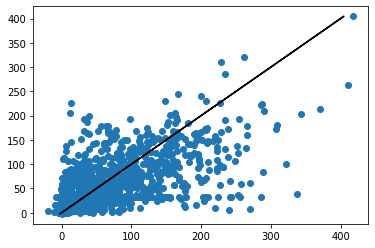

MAE: 33.1
RMSE: 48.8
R^2: 0.41


In [18]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = neighbors.KNeighborsRegressor()
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

#### GridSearchCV

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   22.1s finished


{'metric': 'euclidean', 'n_neighbors': 38, 'weights': 'distance'}


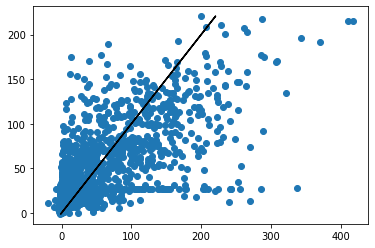

MAE: 31.6
RMSE: 47.4
R^2: 0.45


,param_weights,param_metric,param_n_neighbors,mean_test_score,std_test_score,rank_test_score,mean_fit_time,mean_score_time,std_fit_time,std_score_time
12,distance,euclidean,35,0.450,0.012,11,0.310,0.980,0.015,0.104
14,distance,euclidean,36,0.450,0.011,12,0.306,0.967,0.011,0.134
16,distance,euclidean,37,0.450,0.011,10,0.315,0.974,0.015,0.139
18,distance,euclidean,38,0.454,0.011,1,0.314,0.994,0.020,0.134
20,distance,euclidean,39,0.453,0.011,2,0.306,1.015,0.010,0.132
22,distance,euclidean,40,0.453,0.011,3,0.318,1.002,0.018,0.106
0,distance,manhattan,35,0.448,0.013,18,0.319,1.250,0.017,0.087
2,distance,manhattan,36,0.448,0.013,21,0.309,1.305,0.015,0.123
4,distance,manhattan,37,0.449,0.012,13,0.325,1.284,0.031,0.104
6,distance,manhattan,38,0.451,0.011,6,0.308,1.228,0.012,0.118


In [20]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

params = {
    'weights':['distance','uniform'],
    'metric':['manhattan','euclidean'],
    'n_neighbors':[x for x in range(35,41)],
}

grid = GridSearchCV(
    neighbors.KNeighborsRegressor(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
).fit(X_train,y_train)

print(grid.best_params_)

m = neighbors.KNeighborsRegressor(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

cvGrid(params)

#### GridSearchCV, Standardized

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.4min finished


{'metric': 'manhattan', 'n_neighbors': 41, 'weights': 'distance'}


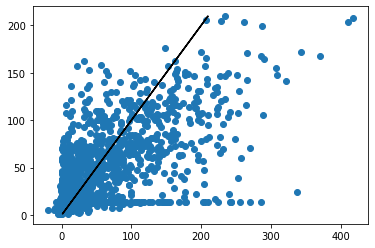

MAE: 30.2
RMSE: 48.4
R^2: 0.42


,param_weights,param_metric,param_n_neighbors,mean_test_score,std_test_score,rank_test_score,mean_fit_time,mean_score_time,std_fit_time,std_score_time
20,distance,euclidean,25,0.418,0.015,40,0.333,2.628,0.010,0.058
21,distance,euclidean,26,0.423,0.015,38,0.335,2.642,0.006,0.061
22,distance,euclidean,27,0.426,0.013,37,0.344,2.680,0.010,0.055
23,distance,euclidean,28,0.429,0.012,35,0.351,2.882,0.024,0.135
24,distance,euclidean,29,0.430,0.012,34,0.463,3.404,0.038,0.320
25,distance,euclidean,30,0.430,0.013,33,0.440,2.985,0.043,0.193
26,distance,euclidean,31,0.431,0.011,31,0.465,3.196,0.059,0.420
27,distance,euclidean,32,0.433,0.011,30,0.553,3.475,0.052,0.280
28,distance,euclidean,33,0.434,0.011,28,0.505,3.360,0.019,0.176
29,distance,euclidean,34,0.435,0.010,24,0.461,3.154,0.074,0.145


In [27]:
X_train, X_dev, y_train, y_dev = X_train_std, X_dev_std, y_train, y_dev

params = {
    'weights':['distance'],
    'metric':['manhattan','euclidean'],
    'n_neighbors':[x for x in range(25,45)],
}

grid = GridSearchCV(
    neighbors.KNeighborsRegressor(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
).fit(X_train,y_train)

print(grid.best_params_)

m = neighbors.KNeighborsRegressor(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

cvGrid(params)

#### GridSearchCV, standardized, hand-selected features

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished


{'metric': 'manhattan', 'n_neighbors': 41, 'weights': 'distance'}


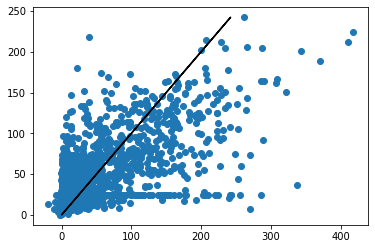

MAE: 31.3
RMSE: 47.3
R^2: 0.45


,param_weights,param_metric,param_n_neighbors,mean_test_score,std_test_score,rank_test_score,mean_fit_time,mean_score_time,std_fit_time,std_score_time
20,distance,euclidean,25,0.455,0.016,39,0.109,0.286,0.011,0.021
21,distance,euclidean,26,0.455,0.016,38,0.107,0.291,0.013,0.021
22,distance,euclidean,27,0.455,0.014,40,0.105,0.377,0.011,0.030
23,distance,euclidean,28,0.456,0.014,34,0.144,0.327,0.023,0.034
24,distance,euclidean,29,0.458,0.015,32,0.110,0.304,0.015,0.021
25,distance,euclidean,30,0.457,0.015,33,0.113,0.304,0.020,0.012
26,distance,euclidean,31,0.458,0.015,31,0.110,0.311,0.014,0.029
27,distance,euclidean,32,0.458,0.015,28,0.105,0.305,0.011,0.028
28,distance,euclidean,33,0.458,0.016,23,0.104,0.302,0.015,0.023
29,distance,euclidean,34,0.458,0.015,25,0.114,0.322,0.019,0.034


In [28]:
X_train, X_dev, y_train, y_dev = X_train_std_select, X_dev_std_select, y_train, y_dev

params = {
    'weights':['distance'],
    'metric':['manhattan','euclidean'],
    'n_neighbors':[x for x in range(25,45)],
}

grid = GridSearchCV(
    neighbors.KNeighborsRegressor(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
).fit(X_train,y_train)

print(grid.best_params_)

m = neighbors.KNeighborsRegressor(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

cvGrid(params)